In [40]:
import h5py
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

In [41]:
# Load in the Dataset
predictions_dir = "../output/positive_evaulation/"
yground = np.load(predictions_dir + "labels.npy")
ylogits = np.load(predictions_dir + "pred_results.npy")
print(f'There are {yground.shape[0]} positive samples being tested.')
num_samples = yground.shape[0]



There are 26157 positive samples being tested.


In [42]:
print(np.count_nonzero(yground == 0)) # num poised
print(np.count_nonzero(yground == 2)) # num active 

15722
10435


In [43]:
## Dictionary Store for FPR Thresholds 
## Load this from Eval Results JSON file. 
POISED_THRESHOLDS = {
    0.10 : -0.39354804158210754,
    0.05 : 0.0886303037405014,
    0.03 : 0.34452739357948303,
    0.01 : 0.8528411388397217,
}

ACTIVE_THRESHOLDS = {
    0.10 : -0.5178720355033875,
    0.05 : -0.11259077489376068,
    0.03 : 0.170790046453475952,
    0.01 : 0.7585378885269165,
}

def predict(logits, fpr):
    assert fpr in [0.10, 0.05, 0.03, 0.01]

    pe_thresh = POISED_THRESHOLDS[fpr]
    ae_thresh = ACTIVE_THRESHOLDS[fpr]
    if logits[0] > pe_thresh and logits[2] > ae_thresh:
        return 0 if logits[0] > logits[2] else 2
    elif logits[0] > pe_thresh:
        return 0
    elif logits[2] > ae_thresh:
        return 2
    else:
        return 1

In [44]:
# First Print Out Overall Accuracy
fpr = 0.05
ypreds = np.apply_along_axis(predict, 1, ylogits, fpr)
usable_ypreds = np.where(ypreds != 1)[0]

fpr_thresh_acc = np.count_nonzero(ypreds == yground) / len(yground)
print(f'Accuracy accounting for FPR: {fpr_thresh_acc}')

valid_pred = ypreds != 1

Accuracy accounting for FPR: 0.5541919944947815


In [74]:
# Plot Function Based on Logits - should see clustering. 
def scale(logits):
    norm = np.linalg.norm(logits, 1)
    return logits / norm

def plot_enhancer(logits, bin_width, enhancer_type, normalized):
    assert enhancer_type in ["Active", "Poised"]

    # Define sampls to bin and count
    bins = np.arange(np.min(logits), np.max(logits), bin_width)
    bin_counts, _ = np.histogram(logits, bins=bins)

    plt.bar(bins[:-1], bin_counts, width=bin_width, align='edge', alpha=0.4, color='blue')
    plt.plot(bins[:-1] + bin_width/2, bin_counts, color='blue')

    plt.xlabel('Acitve Enhancer Score')
    plt.ylabel(f'Number of {enhancer_type} Enhancers')
    if normalized:
        plt.title(f'Normalized Active Enhancer Score versus Number of {enhancer_type} Enhancers')
    else:
        plt.title(f'Unnormalized Active Enhancer Score versus Number of {enhancer_type} Enhancers')
    plt.show()

7935
7935


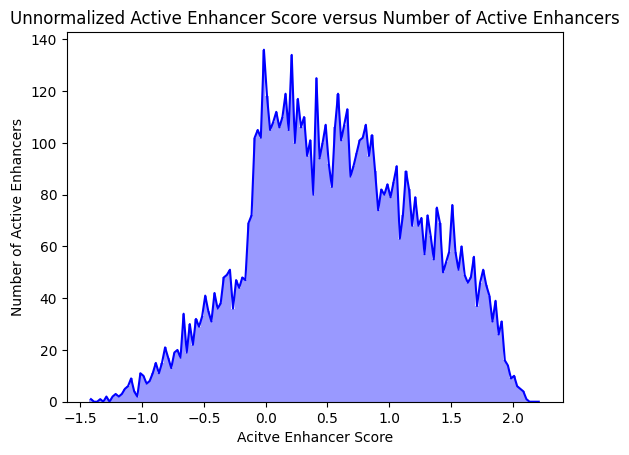

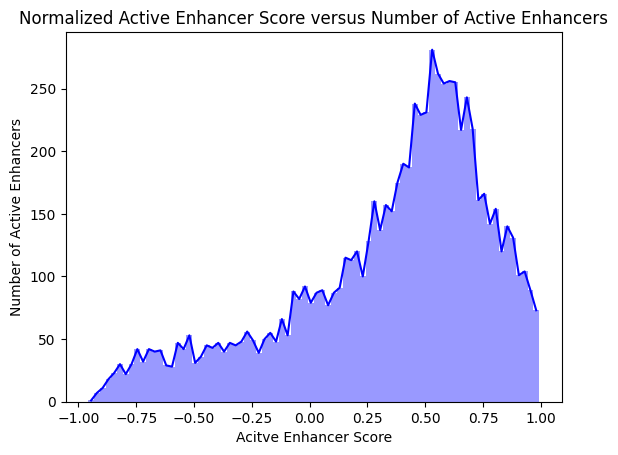

In [46]:
active_condition = np.logical_and(yground == 2, valid_pred)
active_indices = np.where(active_condition)
print(len(active_indices[0]))
# active_indices = np.where(yground == 2)
print(len(active_indices[0]))
active_logits = ylogits[active_indices]
plot_enhancer(active_logits[:,2], 0.025, "Active", False)

active_normed = np.apply_along_axis(scale, 1, np.delete(active_logits, 1, axis=1))
plot_enhancer(active_normed[:,1], 0.025, "Active", True)

12143
12143


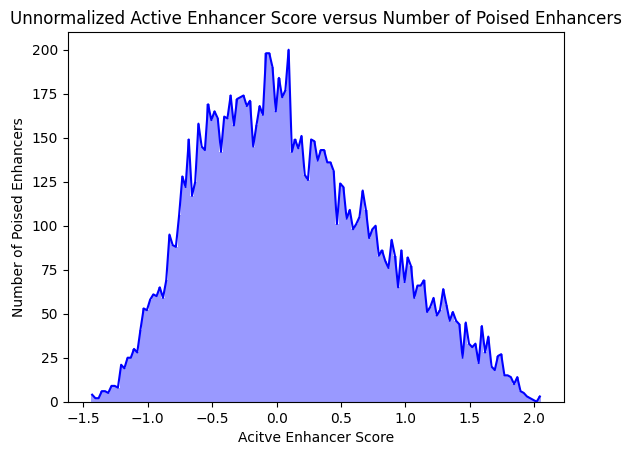

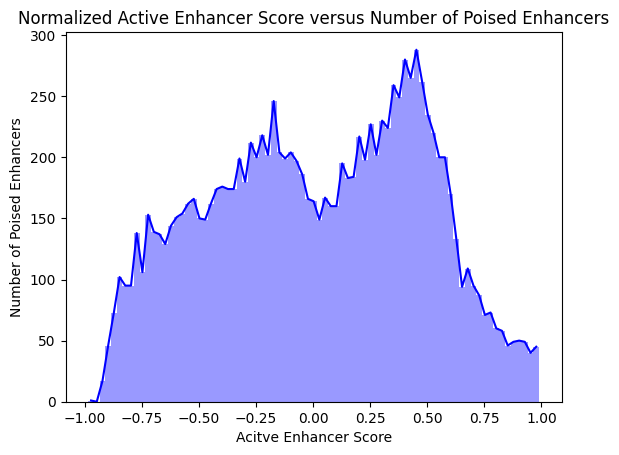

In [12]:
poised_condition = np.logical_and(yground == 0, valid_pred)
poised_indices = np.where(poised_condition)
print(len(poised_indices[0]))
# poised_indices = np.where(yground == 0)
print(len(poised_indices[0]))

poised_logits = ylogits[poised_indices]
plot_enhancer(poised_logits[:,2], 0.025, "Poised", False)

poised_normed = np.apply_along_axis(scale, 1, np.delete(poised_logits, 1, axis=1))
plot_enhancer(poised_normed[:,1], 0.025, "Poised", True)

Loading in all of the Transcription Factor Binding Sites that We Have in a BED File

In [48]:
import pandas as pd
from pybedtools import BedTool

bed_file = "../data/motif_files/EFO-0003042.TFbinding.bed"
tf_sites = list(BedTool(bed_file))

tfsites = []
with open(bed_file, 'r') as file:
    for line in file:
        info = line.split()
        tfsites.append(info)

df_tfsites = pd.DataFrame(tfsites, columns=['Chrom', 'Start', 'End', 'TF'])

from pybedtools import BedTool

positive_bed = "../data/positive.bed"
positive_list = list(BedTool(positive_bed))


In [38]:
normalized_logits = np.apply_along_axis(scale, 1, np.delete(ylogits, 1, axis=1))
active_i = active_indices[0]
peads_i = np.where(np.logical_and(poised_condition, normalized_logits[:,1] < 0.0))[0]
peas_i = np.where(np.logical_and(poised_condition, normalized_logits[:,1] >= 0.0))[0]
print(len(active_i), len(peas_i), len(peads_i))
assert(len(active_i) + len(peas_i) + len(peads_i) == np.count_nonzero(ypreds != 1))

active_b = [positive_list[i] for i in active_i]
peads_b = [positive_list[i] for i in peas_i]
peas_b = [positive_list[i] for i in peads_i]

active_bed = BedTool(active_b)
peads_bed = BedTool(peas_b)
peas_bed = BedTool(peads_b)

active_bed.saveas('../data/active.bed')
peads_bed.saveas('../data/peads.bed')
peas_bed.saveas('../data/peas.bed')

# assert((len(active) + len(poised) + len(p_to_a)) == yground.shape[0])

7935 6302 5841


<BedTool(../data/peas.bed)>

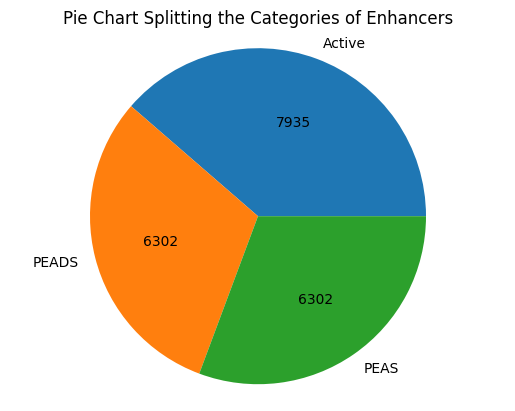

In [55]:
num_active = len(active_i)
num_peads = len(peas_i)
num_peas = len(peas_i)

sizes = {"Active" : num_active, "PEADS" : num_peads, "PEAS" : num_peas}

import matplotlib.pyplot as plt

# Data for the three groups
group_names = ['Active', 'PEADS', 'PEAS']
group_counts = [num_active, num_peads, num_peas]

# Color blind accessible color scheme
colors = ['#1f77b4', '#ff7f0e', '#8c564b']

# Create the pie chart
fig, ax = plt.subplots()
# pie = ax.pie(group_counts, labels=group_names, colors=colors, startangle=90, autopct='%1.1f%%')

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format
plt.pie(group_counts, labels = group_names, autopct = autopct_format(group_counts))

# Add a title
ax.set_title('Pie Chart Splitting the Categories of Enhancers')

# Create a legend
# ax.legend(pie[0], group_names, loc='upper right')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Display the chart
plt.show()

In [64]:
## Read in BED Intersect Files
def read_bed(file):
    sites = []
    with open(file, 'r') as file:
        for line in file:
            info = line.split()
            sites.append(info)
    return sites

tfactive = read_bed("../data/enhancer_files/tfbind_active.bed")
tfpeads = read_bed("../data/enhancer_files/tfbind_peads.bed")
tfpeas = read_bed("../data/enhancer_files/tfbind_peas.bed")

print(len(tfactive), len(tfpeads), len(tfpeas))

98615 32622 52326


In [73]:
def process_intersection(bedlist : list):
    total_intersections = len(bedlist)
    tf_map = {}
    for bed in bedlist:
        tf = bed[3]
        if tf not in tf_map:
            tf_map[tf] = 1
        else:
            tf_map[tf] += 1
    return tf_map, total_intersections

def determine_fold_change(base, experimental, base_name, exp_name):
    tsv = f'base_{base_name}_exp_{exp_name}_FC.tsv'
    tsv_content = "tf\tbase_occur\texp_occur\tfoldchange\n"
    fold_map = {}

    num_b = sizes[base_name]
    num_e = sizes[exp_name]

    all_tfs = list(experimental.keys()) + list(base.keys())
    for tf in all_tfs:
        if tf in base and tf in experimental:
            b_occur = base[tf]
            e_occur = experimental[tf]
            # fold_change = (e_occur / num_e) / (b_occur / num_b)
            fold_change = ((e_occur / num_e) - (b_occur / num_b)) / (b_occur / num_b)
            tsv_content += f"{tf}\t{b_occur}\t{e_occur}\t{fold_change}\n"
            fold_map[tf] = fold_change
        elif tf in base and tf not in experimental:
            b_occur = base[tf]
            e_occur = 0
            fold_change = "nan"
            tsv_content += f"{tf}\t{b_occur}\t{e_occur}\t{fold_change}\n"
        elif tf not in base and tf in experimental:
            b_occur = 0
            e_occur = experimental[tf]
            fold_change = "nan"
            tsv_content += f"{tf}\t{b_occur}\t{e_occur}\t{fold_change}\n"
    
    with open(tsv, 'w') as tsv_file:
        tsv_file.write(tsv_content)
    return fold_map

def plot_histogram(fold_map, base, experimental):
    # Sort the dictionary by fold change values
    sorted_tf_fold_changes = sorted(fold_map.items(), key=lambda x: x[1])

    # Separate positive and negative fold changes
    positive_fold_changes = [fc for fc in fold_map.values() if fc > 0]
    negative_fold_changes = [fc for fc in fold_map.values() if fc < 0]

    # Calculate mean and standard deviation for positive fold changes
    positive_mean = np.mean(positive_fold_changes)
    positive_std = np.std(positive_fold_changes)

    # Exclude positive fold change values more than three standard deviations away from the mean
    excluded_positive_tfs = [(tf, fc) for tf, fc in fold_map.items() if fc > 0 and fc > positive_mean + 5 * positive_std]

    # Calculate mean and standard deviation for negative fold changes
    negative_mean = np.mean(negative_fold_changes)
    negative_std = np.std(negative_fold_changes)

    # Exclude negative fold change values more than three standard deviations away from the mean
    excluded_negative_tfs = [(tf, fc) for tf, fc in fold_map.items() if fc < 0 and fc < negative_mean - 5 * negative_std]

    # Combine the excluded TFs and their fold changes
    excluded_tfs = excluded_positive_tfs + excluded_negative_tfs

    # Remove the excluded TFs from the original dictionary
    for tf, fc in excluded_tfs:
        print(f"Excluded TF: {tf}, Fold Change: {fc}")
        del fold_map[tf]

    # Sort the remaining TFs by their fold change values
    sorted_tf_fold_changes = sorted(fold_map.items(), key=lambda x: x[1])
    sorted_tf_fold_changes.reverse()

    # Extract TF names and fold changes
    tf_names = [tf[0] for tf in sorted_tf_fold_changes]
    fold_changes = [tf[1] for tf in sorted_tf_fold_changes]

    # Define colors for positive and negative fold changes
    colors = ['red' if fc < 0 else 'blue' for fc in fold_changes]

    # Create the bar plot
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.bar(tf_names, fold_changes, color=colors)
    plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align the x-axis labels
    plt.xlabel('Transcription Factor')
    plt.ylabel('Fold Change')
    plt.title(f'Transcription Factor Fold Changes {experimental} Compared to {base}')
    plt.tight_layout()  # Ensure labels fit within the figure

    # Show the plot
    plt.show()

Excluded TF: CBX8, Fold Change: 26.858120437956206


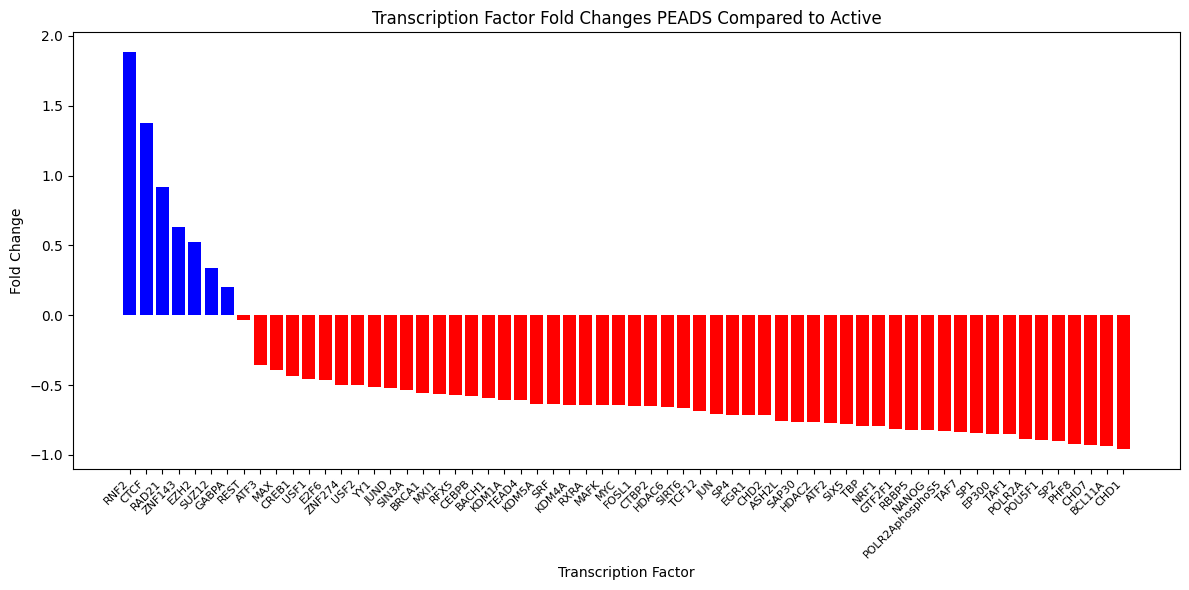

Excluded TF: RNF2, Fold Change: 12.543655249859631


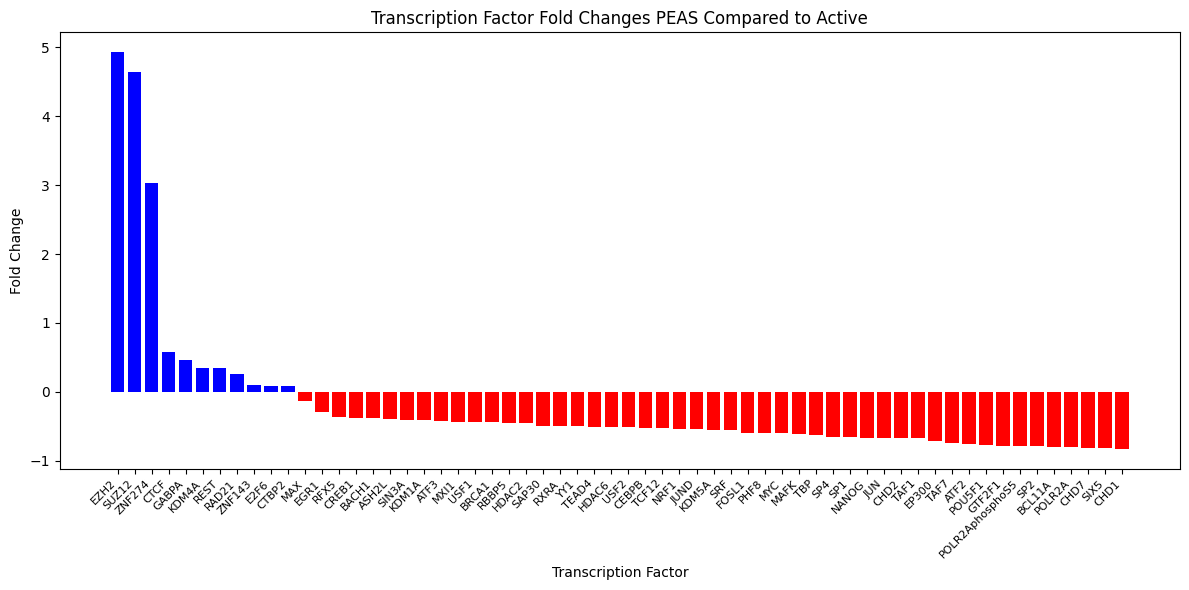

Excluded TF: ZNF274, Fold Change: 7.000000000000001


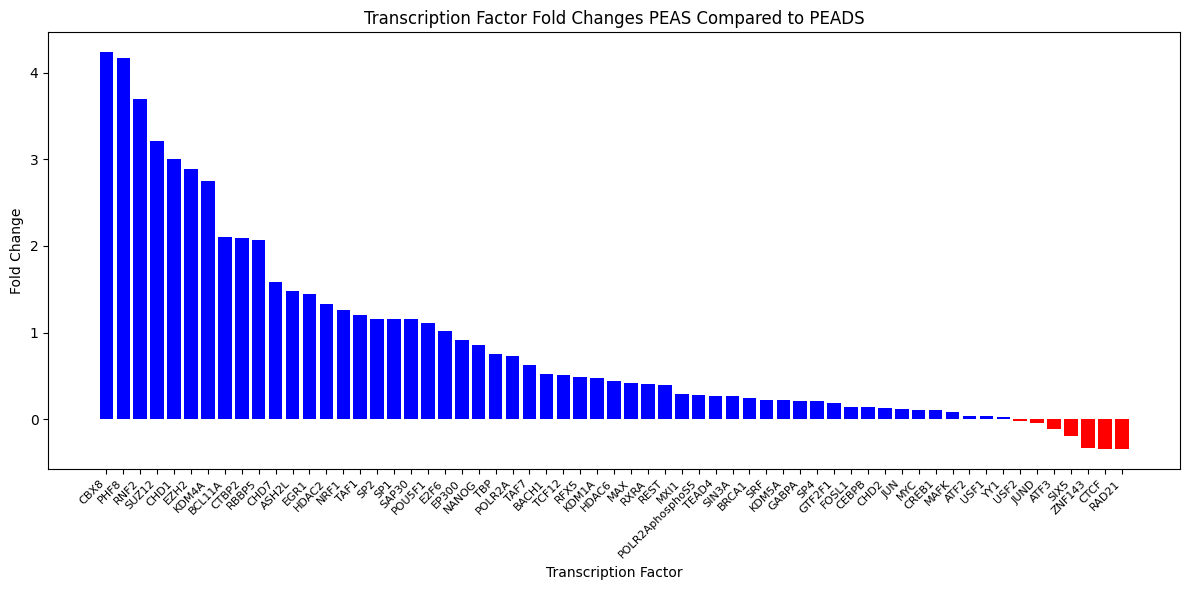

In [72]:
## Process BEDS
map_active, _ = process_intersection(tfactive)
map_poised, _ = process_intersection(tfpeads)
map_p_to_a, _ = process_intersection(tfpeas)

## Active vs Poised
avsp_map = determine_fold_change(map_active, map_poised, "Active", "PEADS")
plot_histogram(avsp_map, "Active", "PEADS")

## Active vs PoisedtoActive
avspa_map = determine_fold_change(map_active, map_p_to_a, "Active", "PEAS")
del avspa_map['CBX8']
plot_histogram(avspa_map, "Active", "PEAS")

## Poised vs Poised_to_Active
pvspa_map = determine_fold_change(map_poised, map_p_to_a, "PEADS", "PEAS")
plot_histogram(pvspa_map, "PEADS", "PEAS")

In [111]:
print(map_active['CBX8'])
print(map_poised['CBX8'])
print(map_p_to_a['CBX8'])


8
566
563
